# 포지션, 나이, WAR, 잔류 여부 포함 기계 학습 도전

## 3차 시기 : 머신러닝 도전
- 연도와 총액을 따로 맞히는 방법을 선택

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df_pi = pd.read_excel('데이터톤 투수 최종 데이터.xlsx')
df_ba = pd.read_excel('데이터톤 야수 최종 데이터.xlsx')

In [ ]:
# 원본 데이터 보존을 위한 카피
df_pi_m3 = df_pi.copy()

df_ba_m3 = df_ba.copy()

In [ ]:
# 일단 필요한 칼럼만 따오기
df_pi_m3 = df_pi_m3[['구단명', '선수명', '포지션', 'Throw', 'Age', '종합 WAR', 'FA 계약 연수', 'FA 계약 총액', '잔류 여부']]
df_ba_m3 = df_ba_m3[['구단명', '선수명', '포지션', 'Throw', 'Bat', 'Age', 'oWAR', 'dWAR', 'FA 계약 연수', 'FA 계약 총액', '잔류 여부']]

df_ba_m3['종합 WAR'] = df_ba_m3['oWAR'] + df_ba_m3['dWAR']
df_ba_m3 = df_ba_m3.drop(['oWAR', 'dWAR'], axis=1)

In [ ]:
# 연도별 성적에 가중치 매기기
df_pi_m3['weight'] = ((df_pi_m3.index % 4) + 1) / 10 * 4
df_ba_m3['weight'] = ((df_ba_m3.index % 4) + 1) / 10 * 4

# 왜 위와 같은 산식을 썼는지?
# 선수의 데이터가 4행 단위로 묶여 있어 인덱스를 4로 나눈 나머지에 1을 더하면 1, 2, 3, 4가 나옴
# 이것을 10으로 나누면 가중치 0.1, 0.2, 0.3, 0.4가 적용됨
# 그러나 1차 시기에서 가중치의 합이 1:1:1:1로 적용됐으므로 동일한 스케일로 조정하기 위해 가중치 합 4가 나오도록 4를 곱함

In [ ]:
# 군 복무한 선수들의 가중치를 이월해서 적용
def apply_weight_with_service_adjustment(df):
    def redistribute_weights(group):
        weights = group['weight'].tolist()
        teams = group['구단명'].tolist()
        new_weights = [0] * len(weights)
        carry_over = 0

        for i in range(len(weights)):
            if teams[i] == '군 복무':
                carry_over += weights[i]  # 군 복무면 이월, 실전 시즌에 누적 가중치 반영
            else:
                new_weights[i] = weights[i] + carry_over
                carry_over = 0            # 반영 후 초기화

        group['new_weight'] = new_weights
        return group

    return df.groupby('선수명', group_keys=False).apply(redistribute_weights)


# 선수명 기준으로 그룹화 후 적용
df_pi_m3 = apply_weight_with_service_adjustment(df_pi_m3)
df_ba_m3 = apply_weight_with_service_adjustment(df_ba_m3)

<ipython-input-5-8616b29d6ee0>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('선수명', group_keys=False).apply(redistribute_weights)
<ipython-input-5-8616b29d6ee0>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('선수명', group_keys=False).apply(redistribute_weights)


In [ ]:
# 4년치의 성적을 선수 단위로 합산

df_pi_m3['group'] = df_pi_m3.groupby('선수명').cumcount() // 4
df_ba_m3['group'] = df_ba_m3.groupby('선수명').cumcount() // 4

df_pi_m3['FA 선언 시점 연령'] = df_pi_m3.groupby(['선수명', 'group'])['Age'].transform(lambda x: x.iloc[-1])
df_ba_m3['FA 선언 시점 연령'] = df_ba_m3.groupby(['선수명', 'group'])['Age'].transform(lambda x: x.iloc[-1])

df_pi_m3 = df_pi_m3.drop('Age', axis=1)
df_ba_m3 = df_ba_m3.drop('Age', axis=1)

# 한 선수가 FA를 여러 번 선언한 적이 있으므로 선수명과 사전에 정의한 그룹을 기준으로 묶기
df_pi_m3 = df_pi_m3.groupby(['선수명', 'group']).agg({
    '포지션': lambda x: x.mode().iloc[0],
    'Throw' : lambda x : x.mode().iloc[0],
    'FA 선언 시점 연령': 'max',
    '종합 WAR': 'sum',
    '잔류 여부': lambda x: x.mode().iloc[0],
    'FA 계약 연수': 'sum',
    'FA 계약 총액': 'sum'
}).reset_index()

df_ba_m3 = df_ba_m3.groupby(['선수명', 'group']).agg({
    '포지션': lambda x: x.mode().iloc[0],
    'Throw' : lambda x : x.mode().iloc[0],
    'Bat' : lambda x : x.mode().iloc[0],
    'FA 선언 시점 연령': 'max',
    '종합 WAR': 'sum',
    '잔류 여부': lambda x: x.mode().iloc[0],
    'FA 계약 연수': 'sum',
    'FA 계약 총액': 'sum'
}).reset_index()

In [ ]:
# 해외 이적 선수는 kbo 안에서 계약한 것이 아니고 은퇴 선수는 계약 내역이 없어 이적/잔류 케이스만 추출
df_pi_m3 = df_pi_m3[df_pi_m3['잔류 여부'].isin(['이적', '잔류'])]
df_ba_m3 = df_ba_m3[df_ba_m3['잔류 여부'].isin(['이적', '잔류'])]

In [ ]:
# 필요 없는 칼럼 제거
df_pi_m3 = df_pi_m3.drop('group', axis=1)
df_ba_m3 = df_ba_m3.drop('group', axis=1)

In [ ]:
# 테스트 데이터에도 동일한 처리 진행

df_pi_25 = pd.read_excel('2025 KBO 투수 FA.xlsx')
df_ba_25 = pd.read_excel('2025 KBO 야수 FA.xlsx')

df_pi_25 = df_pi_25[['구단명', '선수명', '포지션', 'Throw', 'Age', '종합 WAR', 'FA 계약 연수', 'FA 계약 총액', '잔류 여부']]
df_ba_25 = df_ba_25[['구단명', '선수명', '포지션', 'Throw', 'Bat', 'Age', 'oWAR', 'dWAR', 'FA 계약 연수', 'FA 계약 총액', '잔류 여부']]

df_ba_25['종합 WAR'] = df_ba_25['oWAR'] + df_ba_25['dWAR']
df_ba_25 = df_ba_25.drop(['oWAR', 'dWAR'], axis=1)

In [ ]:
# 연도별 성적에 가중치 매기기
df_pi_25['weight'] = ((df_pi_25.index % 4) + 1) / 10 * 4
df_ba_25['weight'] = ((df_ba_25.index % 4) + 1) / 10 * 4

In [ ]:
# 군 가중치 이월 함수 적용
df_pi_25 = apply_weight_with_service_adjustment(df_pi_25)
df_ba_25 = apply_weight_with_service_adjustment(df_ba_25)

In [ ]:
df_pi_25['group'] = df_pi_25.groupby('선수명').cumcount() // 4
df_ba_25['group'] = df_ba_25.groupby('선수명').cumcount() // 4

df_pi_25['FA 선언 시점 연령'] = df_pi_25.groupby(['선수명', 'group'])['Age'].transform(lambda x: x.iloc[-1])
df_ba_25['FA 선언 시점 연령'] = df_ba_25.groupby(['선수명', 'group'])['Age'].transform(lambda x: x.iloc[-1])

df_pi_25 = df_pi_25.drop('Age', axis=1)
df_ba_25 = df_ba_25.drop('Age', axis=1)

df_pi_25 = df_pi_25.groupby(['선수명', 'group']).agg({
    '포지션': lambda x: x.mode().iloc[0],
    'Throw' : lambda x : x.mode().iloc[0],
    'FA 선언 시점 연령': 'max',
    '종합 WAR': 'sum',
    '잔류 여부': lambda x: x.mode().iloc[0],
    'FA 계약 연수': 'sum',
    'FA 계약 총액': 'sum'
}).reset_index()

df_ba_25 = df_ba_25.groupby(['선수명', 'group']).agg({
    '포지션': lambda x: x.mode().iloc[0],
    'Throw' : lambda x : x.mode().iloc[0],
    'Bat' : lambda x : x.mode().iloc[0],
    'FA 선언 시점 연령': 'max',
    '종합 WAR': 'sum',
    '잔류 여부': lambda x: x.mode().iloc[0],
    'FA 계약 연수': 'sum',
    'FA 계약 총액': 'sum'
}).reset_index()

In [ ]:
# 해외 이적 선수는 kbo 안에서 계약한 것이 아니고 은퇴 선수는 계약 내역이 없어 이적/잔류 케이스만 추출
df_pi_25 = df_pi_25[df_pi_25['잔류 여부'].isin(['이적', '잔류'])]
df_ba_25 = df_ba_25[df_ba_25['잔류 여부'].isin(['이적', '잔류'])]

In [ ]:
# 필요없는 칼럼 정리
df_pi_25 = df_pi_25.drop('group', axis=1)
df_ba_25 = df_ba_25.drop('group', axis=1)

In [ ]:
# 선수명은 계약 결과와 무관하므로 따로 임시 보관
# 투수 선수명 분리
names_pi_3 = df_pi_m3['선수명']
df_pi_m3 = df_pi_m3.drop('선수명', axis=1)

names_pi_25 = df_pi_25['선수명']
df_pi_25 = df_pi_25.drop('선수명', axis=1)

# 야수 선수명 분리
names_ba_3 = df_ba_m3['선수명']
df_ba_m3 = df_ba_m3.drop('선수명', axis=1)

names_ba_25 = df_ba_25['선수명']
df_ba_25 = df_ba_25.drop('선수명', axis=1)

In [ ]:
# 연수 예측 자료와 총액 예측 자료를 분리
df_pi_m3_year = df_pi_m3[['포지션', 'Throw', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 연수']]
df_pi_m3_value = df_pi_m3[['포지션', 'Throw', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 총액']]
df_pi_25_year = df_pi_25[['포지션', 'Throw', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 연수']]
df_pi_25_value = df_pi_25[['포지션', 'Throw', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 총액']]

df_ba_m3_year = df_ba_m3[['포지션', 'Throw', 'Bat', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 연수']]
df_ba_m3_value = df_ba_m3[['포지션', 'Throw', 'Bat','FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 총액']]
df_ba_25_year = df_ba_25[['포지션', 'Throw', 'Bat', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 연수']]
df_ba_25_value = df_ba_25[['포지션', 'Throw', 'Bat', 'FA 선언 시점 연령', '종합 WAR', '잔류 여부', 'FA 계약 총액']]

In [ ]:
# 연수 데이터 분할
target_pi_year = df_pi_m3_year.pop('FA 계약 연수')
real_pi_year = df_pi_25_year.pop('FA 계약 연수')

target_ba_year = df_ba_m3_year.pop('FA 계약 연수')
real_ba_year = df_ba_25_year.pop('FA 계약 연수')

from sklearn.model_selection import *

x_pi_year_train, x_pi_year_val, y_pi_year_train, y_pi_year_val = train_test_split(df_pi_m3_year, target_pi_year, test_size=0.2, random_state=0)
x_ba_year_train, x_ba_year_val, y_ba_year_train, y_ba_year_val = train_test_split(df_ba_m3_year, target_ba_year, test_size=0.2, random_state=0)

### 분류 모델 분석

#### 투수 먼저 분석 진행

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# 컬럼 구분
features_pi = ['포지션', 'Throw', '잔류 여부']

# 전처리기 정의
preprocessor_pi = ColumnTransformer(transformers=[('fa_pi', OneHotEncoder(handle_unknown='ignore'), features_pi)], remainder='passthrough')

# 전체 파이프라인
pipeline_pi_year_rfc = Pipeline(steps=[
    ('preprocessing', preprocessor_pi),
    ('classifier', RandomForestClassifier(n_jobs=-1))
    ])

# 훈련
pipeline_pi_year_rfc.fit(x_pi_year_train, y_pi_year_train)

# 예측
y_pred_pi_year = pipeline_pi_year_rfc.predict(x_pi_year_val)

# 검증용 데이터로 1차 분류 성능 확인
from sklearn.metrics import *
report_year_val = classification_report(y_pi_year_val, y_pred_pi_year)
print(report_year_val)

# 검증용 데이터에서는 f1이 0.7로 상당히 높게 관찰

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       1.00      0.67      0.80         6
         3.0       0.00      0.00      0.00         0
         4.0       0.62      0.83      0.71         6

    accuracy                           0.69        13
   macro avg       0.41      0.38      0.38        13
weighted avg       0.75      0.69      0.70        13



In [ ]:
# 실제 테스트용 데이터를 예측
y_prediction_pi_year = pipeline_pi_year_rfc.predict(df_pi_25_year)

report_year_test = classification_report(real_pi_year, y_prediction_pi_year)
print(report_year_test)

              precision    recall  f1-score   support

         2.0       0.20      1.00      0.33         1
         3.0       0.00      0.00      0.00         4
         4.0       0.83      0.83      0.83         6

    accuracy                           0.55        11
   macro avg       0.34      0.61      0.39        11
weighted avg       0.47      0.55      0.48        11



In [ ]:
# 하이퍼파라미터 튜닝
params = {'classifier__n_estimators' : [100, 200, 300],
          'classifier__max_depth' : [5, 7, 9],
          'classifier__ccp_alpha' : [0.0001, 0.0005, 0.001],
          }

grid_search_rfc = GridSearchCV(pipeline_pi_year_rfc, param_grid = params, cv=5, scoring='f1_weighted')

grid_search_rfc.fit(x_pi_year_train, y_pi_year_train)


grid_search_rfc.best_estimator_

# ccp_alpha=0.0001, max_depth=7, n_estimators=200일 때 가장 성능이 좋음

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fa_pi',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['포지션', 'Throw', '잔류 여부'])])),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=0.0005, max_depth=9,
                                        n_estimators=200, n_jobs=-1))])

In [ ]:
# 파이프라인에 베스트 파라미터를 넣고 구동
pipeline_pi_year_rfc = Pipeline(steps=[
    ('preprocessing', preprocessor_pi),
    ('classifier', RandomForestClassifier(n_jobs = -1, n_estimators = 200, max_depth = 9, ccp_alpha = 0.0005, random_state = 0))
    ])

# 훈련
pipeline_pi_year_rfc.fit(x_pi_year_train, y_pi_year_train)

# 예측
y_pred_pi_year = pipeline_pi_year_rfc.predict(x_pi_year_val)

# 검증용 데이터로 1차 분류 성능 확인
from sklearn.metrics import *
report_year_val = classification_report(y_pred_pi_year, y_pi_year_val)
print(report_year_val)
print('===================================================')

# 실제 테스트용 데이터를 예측
y_prediction_pi_year = pipeline_pi_year_rfc.predict(df_pi_25_year)

report_year_test = classification_report(real_pi_year, y_prediction_pi_year)
print(report_year_test)

# 훈련/검증용 데이터 내에선 예측력이 상당히 높음
# 그러나 테스트용에서 갑자기 분류 성능이 떨어진 것이 관찰 → 그리드서치가 찾아낸 최적의 조합이 훈련용 데이터에만 적합한 초매개변수로 추정

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.67      0.80      0.73         5
         3.0       0.00      0.00      0.00         1
         4.0       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.33      0.34      0.34        13
weighted avg       0.62      0.62      0.61        13

              precision    recall  f1-score   support

         2.0       0.20      1.00      0.33         1
         3.0       0.00      0.00      0.00         4
         4.0       0.83      0.83      0.83         6

    accuracy                           0.55        11
   macro avg       0.34      0.61      0.39        11
weighted avg       0.47      0.55      0.48        11



In [ ]:
# 한글 폰트 깨짐 방지 코드 실행
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,790 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and dire

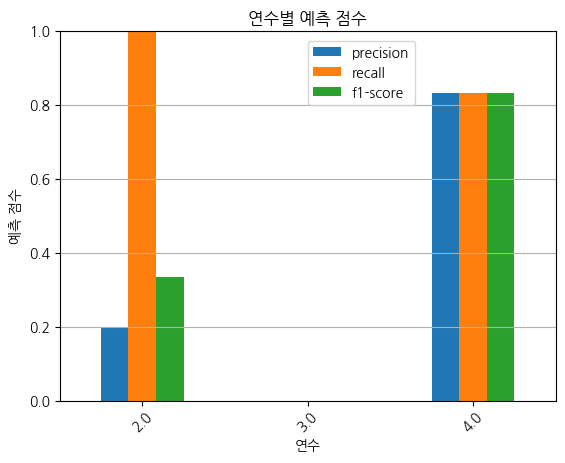

In [ ]:
# 혼동행렬 시각화
import matplotlib.pyplot as plt
report_dict = classification_report(real_pi_year, y_prediction_pi_year, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.loc[report_df.index.notnull() & ~report_df.index.str.contains('accuracy|macro|weighted')]

report_df[metrics].plot(kind='bar')
plt.title('연수별 예측 점수')
plt.ylabel('예측 점수')
plt.xlabel('연수')

plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc=(0.5, 0.8))
plt.show()

# 다른 연수에 비해 2년의 precision과 3년의 점수가 매우 낮은 것이 확인

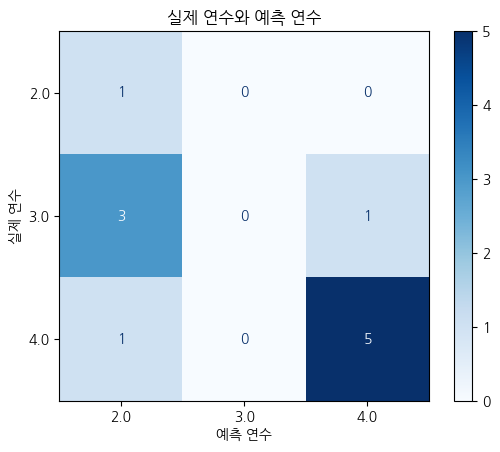

In [ ]:
# 2024-2025 오프시즌은 다른 FA 시장에 비해 이례적일 만큼 3년 계약이 많은 해였음
# 2013~2024 오프시즌 중 투수의 FA 3년 계약은 63건 중 11건이나 지난 오프시즌은 11건 중 4건이 3년 계약
# 오프시즌 시작 전을 기준 시점으로 한 예측 분석이므로 이러한 이례적인 연수 비중 변도를 고려하지 못한 것

ConfusionMatrixDisplay.from_predictions(real_pi_year, y_prediction_pi_year, cmap='Blues', normalize=None)
plt.title('실제 연수와 예측 연수')
plt.ylabel('실제 연수')
plt.xlabel('예측 연수')
plt.show()

In [ ]:
results_df = pd.DataFrame({'선수명' : names_pi_25,
                           '예측_FA연수' : y_prediction_pi_year.astype('int'),
                           '실제 FA연수' : real_pi_year.values.astype('int')})

results_df

# 불펜투수들은 소모적으로 투입되는 특성으로 인해 선수생명이 짧아 30대 후반까지 롱런하는 경우가 많지 않음
# 김강률, 노경은, 이용찬 등 1~2년 계약을 맺을 법한 30대 후반 선수들이 3~4년 계약을 획득하면서 모델 예측이 틀어진 것으로 판단

,선수명,예측_FA연수,실제 FA연수
0,구승민,2,4
1,김강률,4,4
2,김원중,4,4
3,노경은,2,3
5,엄상백,4,4
6,우규민,2,2
7,이용찬,2,3
8,임기영,4,3
9,임정호,2,3
10,장현식,4,4


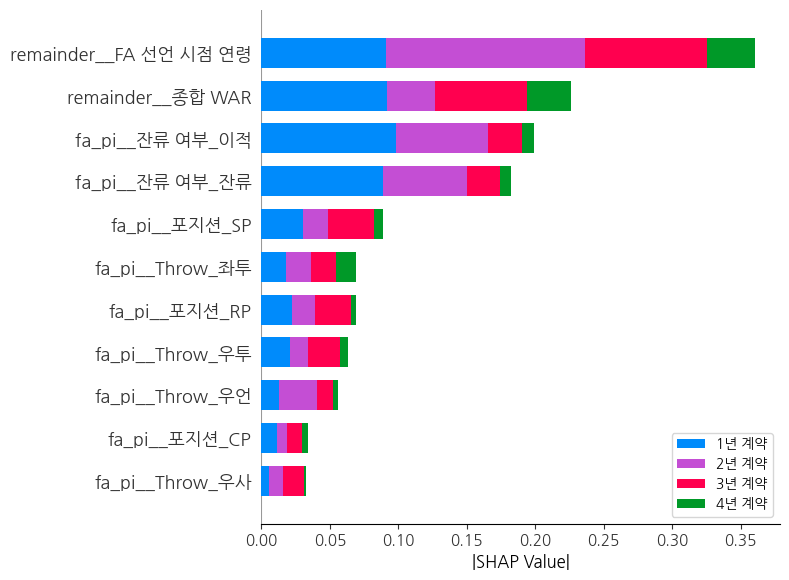

In [ ]:
# shap 차트 구성
import shap

# 파이프라인에서 모델 꺼내기
rfc_model_pi = pipeline_pi_year_rfc.named_steps['classifier']

# shap explainer 생성
explainer_pi_year = shap.Explainer(rfc_model_pi)

# 전처리 후의 입력 데이터 얻기 (transform만)
x_val_transformed_pi = pipeline_pi_year_rfc.named_steps['preprocessing'].transform(x_pi_year_val)

# shap 값 계산
shap_values_pi_year = explainer_pi_year(x_val_transformed_pi)

# 요약 플롯 (plot 객체 저장)
plt.figure() # 새로운 Figure 생성
shap.summary_plot(shap_values_pi_year, x_val_transformed_pi, feature_names=pipeline_pi_year_rfc.named_steps['preprocessing'].get_feature_names_out(), plot_type='bar', show=False)
plt.xlabel('|SHAP Value|', fontsize=12)

# 현재 axes 객체 얻기
ax = plt.gca()

# 범례 핸들과 레이블 얻기
handles, labels = ax.get_legend_handles_labels()

# 새로운 레이블 리스트 생성
new_labels = ['1년 계약', '2년 계약', '3년 계약', '4년 계약']

# 범례 업데이트 및 위치 변경
ax.legend(handles, new_labels, loc='lower right')

plt.tight_layout()
plt.show()

#### 야수도 진행

In [ ]:
# 파이프라인 구성
features_ba = ['포지션', 'Throw', 'Bat', '잔류 여부']

preprocessor_ba = ColumnTransformer(transformers=[('fa_ba', OneHotEncoder(handle_unknown='ignore'), features_ba)], remainder='passthrough')

pipeline_ba_year_rfc = Pipeline(steps=[
    ('preprocessing', preprocessor_ba),
    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=0))
    ])

pipeline_ba_year_rfc.fit(x_ba_year_train, y_ba_year_train)
y_pred_ba_year = pipeline_ba_year_rfc.predict(x_ba_year_val)

report_ba_year_val = classification_report(y_ba_year_val, y_pred_ba_year)
print(report_ba_year_val)

# 검증용 데이터에서는 f1이 0.37로 평범한 수준

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.56      1.00      0.71         5
         3.0       0.00      0.00      0.00         5
         4.0       0.62      0.62      0.62        13
         6.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         1

    accuracy                           0.48        27
   macro avg       0.20      0.27      0.22        27
weighted avg       0.40      0.48      0.43        27



In [ ]:
# 실제 테스트용 데이터를 예측
y_prediction_ba_year = pipeline_ba_year_rfc.predict(df_ba_25_year)

report_ba_year_test = classification_report(real_ba_year, y_prediction_ba_year)
print(report_ba_year_test)

# 테스트 데이터에선 1, 3년 계약을 맞히지 못해 f1 스코어가 하강

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.67      1.00      0.80         2
         3.0       0.00      0.00      0.00         1
         4.0       1.00      0.75      0.86         4

    accuracy                           0.62         8
   macro avg       0.42      0.44      0.41         8
weighted avg       0.67      0.62      0.63         8



In [ ]:
# 하이퍼파라미터 튜닝
params_rfc_ba = {'classifier__n_estimators' : [50, 100, 150],
          'classifier__max_depth' : [5, 10, 15],
          'classifier__ccp_alpha' : [0.0001, 0.0005, 0.001]
          }

grid_search_rfc_ba = GridSearchCV(pipeline_ba_year_rfc, param_grid = params_rfc_ba, cv=5, scoring='f1_weighted')

grid_search_rfc_ba.fit(x_ba_year_train, y_ba_year_train)

grid_search_rfc_ba.best_estimator_

# ccp_alpha=0.0001, max_depth=10, n_estimators=100일 때 최적

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fa_ba',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['포지션', 'Throw', 'Bat',
                                                   '잔류 여부'])])),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=0.0001, max_depth=10,
                                        n_jobs=-1, random_state=0))])

In [ ]:
# 파이프라인에 베스트 파라미터를 넣고 구동
pipeline_ba_year_rfc = Pipeline(steps=[
    ('preprocessing', preprocessor_ba),
    ('classifier', RandomForestClassifier(n_jobs = -1, n_estimators = 100, ccp_alpha=0.0001, max_depth=10, random_state = 0))
    ])

pipeline_ba_year_rfc.fit(x_ba_year_train, y_ba_year_train)

y_pred_ba_year = pipeline_ba_year_rfc.predict(x_ba_year_val)

report_ba_year_val = classification_report(y_pred_ba_year, y_ba_year_val)
print(report_ba_year_val)
print('===================================================')

y_prediction_ba_year = pipeline_ba_year_rfc.predict(df_ba_25_year)

report_ba_year_test = classification_report(real_ba_year, y_prediction_ba_year)
print(report_ba_year_test)

# 1년, 3년 계약을 맞히지 못했으나 4년 계약을 정확히 맞혀 재조정 후 예측력 상승
# 이 분석 모델 결과를 반영

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.56      0.71         9
         3.0       0.00      0.00      0.00         2
         4.0       0.69      0.64      0.67        14
         6.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         0

    accuracy                           0.52        27
   macro avg       0.28      0.20      0.23        27
weighted avg       0.69      0.52      0.58        27

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.67      1.00      0.80         2
         3.0       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         4

    accuracy                           0.75         8
   macro avg       0.42      0.50      0.45         8
weighted avg       0.67      0.75      0.70         8



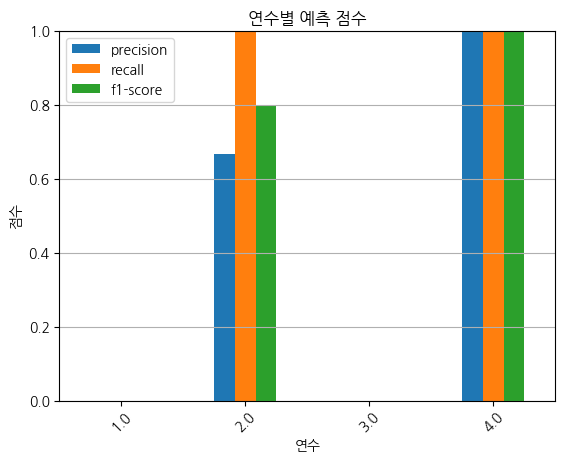

In [ ]:
# 혼동행렬 시각화
report_dict_ba = classification_report(real_ba_year, y_prediction_ba_year, output_dict=True)
report_df_ba = pd.DataFrame(report_dict_ba).transpose()

metrics = ['precision', 'recall', 'f1-score']
report_df_ba = report_df_ba.loc[report_df_ba.index.notnull() & ~report_df_ba.index.str.contains('accuracy|macro|weighted')]

import matplotlib.pyplot as plt
report_df_ba[metrics].plot(kind='bar')
plt.title('연수별 예측 점수')
plt.xlabel('연수')
plt.ylabel('점수')

plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

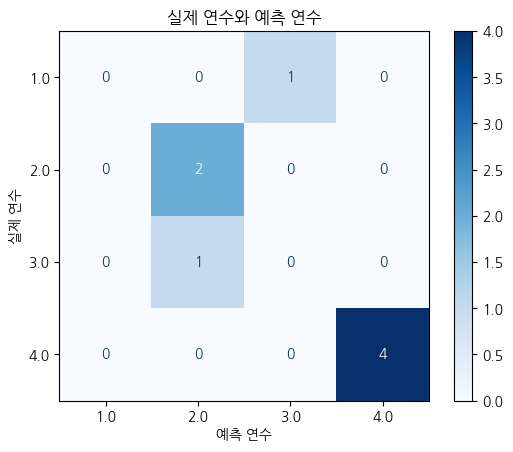

In [ ]:
# 히트맵 호출
ConfusionMatrixDisplay.from_predictions(real_ba_year, y_prediction_ba_year, cmap='Blues', normalize=None)
plt.title('실제 연수와 예측 연수')
plt.ylabel('실제 연수')
plt.xlabel('예측 연수')
plt.show()

# 1년과 3년 계약은 과거부터 비중이 낮은 연수로 지난해도 1건씩밖에 나오지 않았음
# 2,4년 계약 비중이 절대적인 과거 데이터를 감안하면 1,3년 계약에 대한 예측력에 한계가 있는 것은 어쩔 수 없는 부분

In [ ]:
results_df = pd.DataFrame({'선수명' : names_ba_25,
                           '예측 FA 연수' : y_prediction_ba_year.astype('int'),
                           '실제 FA 연수' : real_ba_year.values.astype('int')})

results_df

,선수명,예측 FA 연수,실제 FA 연수
0,김성욱,2,3
1,김헌곤,2,2
2,류지혁,4,4
3,서건창,2,2
4,심우준,4,4
5,최정,4,4
6,하주석,3,1
7,허경민,4,4


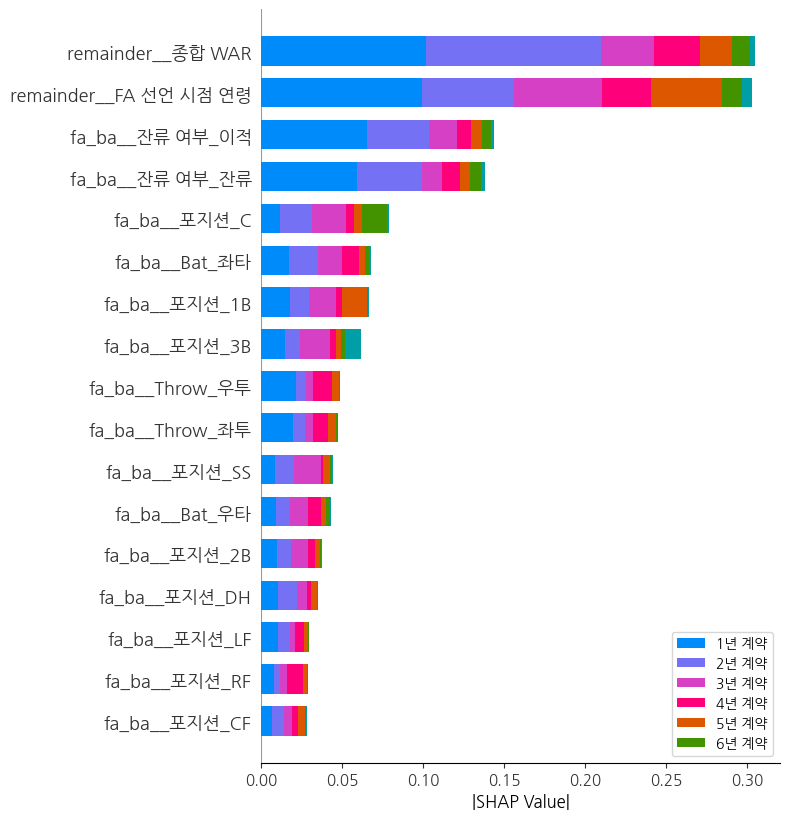

In [ ]:
# shap 차트 구성
import shap

rfc_model_ba = pipeline_ba_year_rfc.named_steps['classifier']

explainer_ba_year = shap.Explainer(rfc_model_ba)

x_val_transformed_ba = pipeline_ba_year_rfc.named_steps['preprocessing'].transform(x_ba_year_val)


shap_values_ba_year = explainer_ba_year(x_val_transformed_ba)

plt.figure()
shap.summary_plot(shap_values_ba_year, x_val_transformed_ba, feature_names=pipeline_ba_year_rfc.named_steps['preprocessing'].get_feature_names_out(), plot_type='bar', show=False)
plt.xlabel('|SHAP Value|', fontsize=12)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = ['1년 계약', '2년 계약', '3년 계약', '4년 계약', '5년 계약', '6년 계약']
ax.legend(handles, new_labels, loc='lower right')

plt.tight_layout()
plt.show()

**하주석은 fa 직전 시즌에 제일 부진하는 바람에 단년 계약을 맺은 케이스**
- 모델이 3년 계약을 따냈어도 좋았을 선수로 꼽은 하주석은 실제로 올해 공수 양면에서 전반적으로 평균 이상의 지표를 보이고 있음


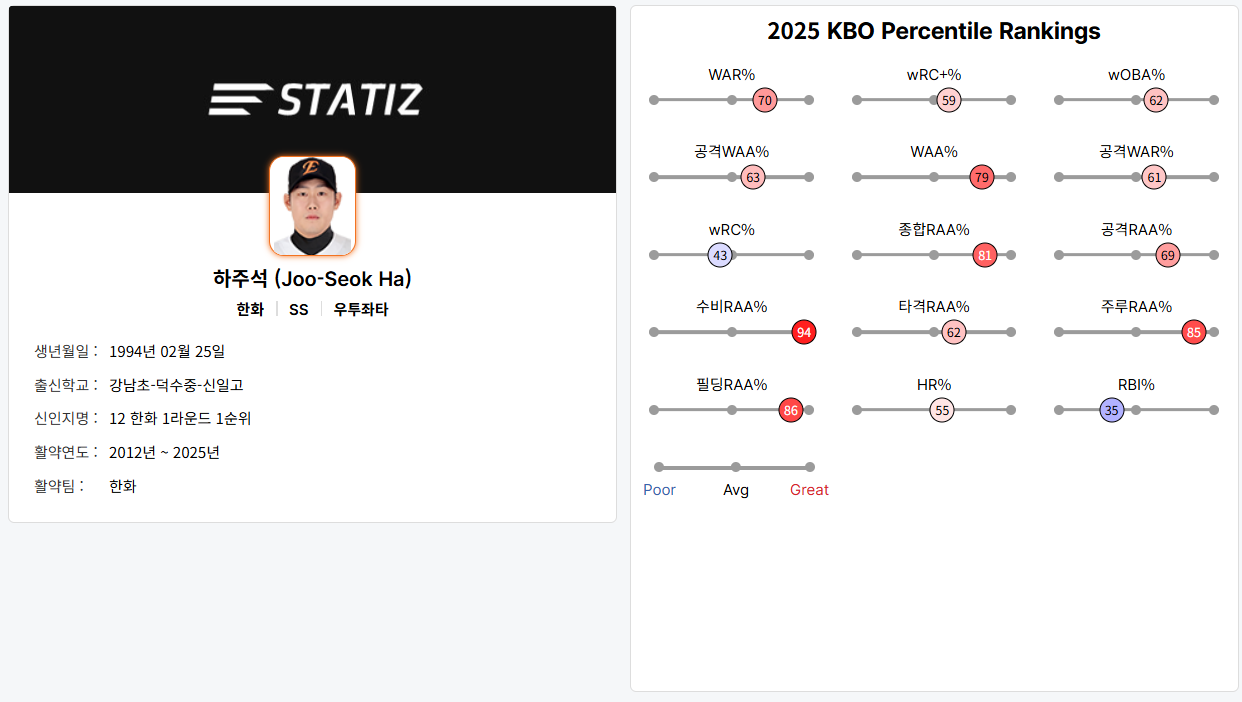

### 회귀 모델 분석 진행

In [ ]:
# 총액 데이터 분할
target_pi_value = df_pi_m3_value.pop('FA 계약 총액')
real_pi_value = df_pi_25_value.pop('FA 계약 총액')

target_ba_value = df_ba_m3_value.pop('FA 계약 총액')
real_ba_value = df_ba_25_value.pop('FA 계약 총액')

from sklearn.model_selection import *

x_pi_value_train, x_pi_value_val, y_pi_value_train, y_pi_value_val = train_test_split(df_pi_m3_value, target_pi_value, test_size=0.2, random_state=0)
x_ba_value_train, x_ba_value_val, y_ba_value_train, y_ba_value_val = train_test_split(df_ba_m3_value, target_ba_value, test_size=0.2, random_state=0)

KeyError: 'FA 계약 총액'

In [ ]:
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestRegressor

# 파이프라인 구성
features_pi = ['포지션', 'Throw', '잔류 여부']

preprocessor_pi = ColumnTransformer(transformers=[('fa_ba', OneHotEncoder(handle_unknown='ignore'), features_pi)], remainder='passthrough')

pipeline_pi_value_rfr = Pipeline(steps=[
    ('preprocessing', preprocessor_pi),
    ('regressor', RandomForestRegressor(n_jobs=-1, random_state=0))
    ])

pipeline_pi_value_rfr.fit(x_pi_value_train, y_pi_value_train)

y_pred_pi_value = pipeline_pi_value_rfr.predict(x_pi_value_val)


print(f'R^2 : {r2_score(y_pi_value_val, y_pred_pi_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(y_pi_value_val, y_pred_pi_value) : .0f}억 원')

# 훈련용 데이터가 검증용 데이터를 잘 예측하지 못했음

R^2 :  0.4157
RMSE :  18억 원


In [ ]:
# 실제 테스트용 데이터를 예측
y_prediction_pi_value = pipeline_pi_value_rfr.predict(df_pi_25_value)

print(f'R^2 : {r2_score(real_pi_value, y_prediction_pi_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(real_pi_value, y_prediction_pi_value) : .0f}억 원')

# 테스트 데이터에 대해선 상당히 높은 예측력 발휘
# 검증용 데이터에 일시적인 문제가 있는 걸까?

R^2 :  0.7727
RMSE :  12억 원


In [ ]:
# 하이퍼파라미터 튜닝
params_rfr_pi = {'regressor__n_estimators' : [100, 200, 300],
          'regressor__max_depth' : [5, 10, 15],
          'regressor__ccp_alpha' : [0.0001, 0.0005, 0.001]
          }

grid_search_rfr_pi_reg = GridSearchCV(pipeline_pi_value_rfr, param_grid = params_rfr_pi, cv=5, scoring='f1_weighted')

grid_search_rfr_pi_reg.fit(x_pi_value_train, y_pi_value_train)


grid_search_rfr_pi_reg.best_estimator_

# ccp_alpha=0.0001, max_depth=5, n_estimators=100일 때 최적

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fa_pi',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['포지션', 'Throw', '잔류 여부'])])),
                ('regressor',
                 RandomForestRegressor(ccp_alpha=0.0001, max_depth=5, n_jobs=-1,
                                       random_state=0))])

In [ ]:
# 최적화 하이퍼파라미터로 재시도
features_pi = ['포지션', 'Throw', '잔류 여부']

preprocessor_pi = ColumnTransformer(transformers=[('fa_pi', OneHotEncoder(handle_unknown='ignore'), features_pi)], remainder='passthrough')

pipeline_pi_value_rfr = Pipeline(steps=[
    ('preprocessing', preprocessor_pi),
    ('regressor', RandomForestRegressor(n_estimators=100, ccp_alpha=0.0001, max_depth = 5, n_jobs=-1, random_state = 0))
    ])

pipeline_pi_value_rfr.fit(x_pi_value_train, y_pi_value_train)

y_pred_pi_val = pipeline_pi_value_rfr.predict(x_pi_value_val)

print(f'R^2 : {r2_score(y_pi_value_val, y_pred_pi_val) : .4f}')
print(f'RMSE : {root_mean_squared_error(y_pi_value_val, y_pred_pi_val) : .0f}억 원')

# 하이퍼파라미터 조정을 여러 번 해도 쉽게 초기 조합보다 좋은 조합을 찾을 수 없음

R^2 :  0.4020
RMSE :  18억 원


In [ ]:
# 실제 테스트용 데이터를 다시 예측
y_prediction_pi_value = pipeline_pi_value_rfr.predict(df_pi_25_value)

print(f'R^2 : {r2_score(real_pi_value, y_prediction_pi_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(real_pi_value, y_prediction_pi_value) : .0f}억 원')

# 재조정한 하이퍼파라미터로 테스트 데이터를 다시 예측한 결과 예측력이 오히려 상승
# 이 조합 사용

R^2 :  0.7874
RMSE :  11억 원


In [ ]:
results_df = pd.DataFrame({'선수명' : names_pi_25,
                           '예측 FA 연수' : y_prediction_pi_year.astype('int'),
                           '예측 FA 총액' : y_prediction_pi_value,
                           '실제 FA 연수' : real_pi_year.values.astype('int'),
                           '실제 FA 총액' : real_pi_value.values,
                           })

results_df

# 김강률, 엄상백, 우규민, 이용찬, 최원태 계약에서 놀라운 수준의 적중률
# 김원중, 노경은, 임기영 계약에서 오차가 크게 났음

,선수명,예측 FA 연수,예측 FA 총액,실제 FA 연수,실제 FA 총액
0,구승민,2,9.184374,4,21.0
1,김강률,4,14.199752,4,14.0
2,김원중,4,32.443729,4,54.0
3,노경은,2,13.302692,3,25.0
5,엄상백,4,74.661690,4,78.0
6,우규민,2,5.522814,2,7.0
7,이용찬,2,10.648018,3,10.0
8,임기영,4,36.904508,3,15.0
9,임정호,3,9.337771,3,12.0
10,장현식,4,38.325226,4,52.0


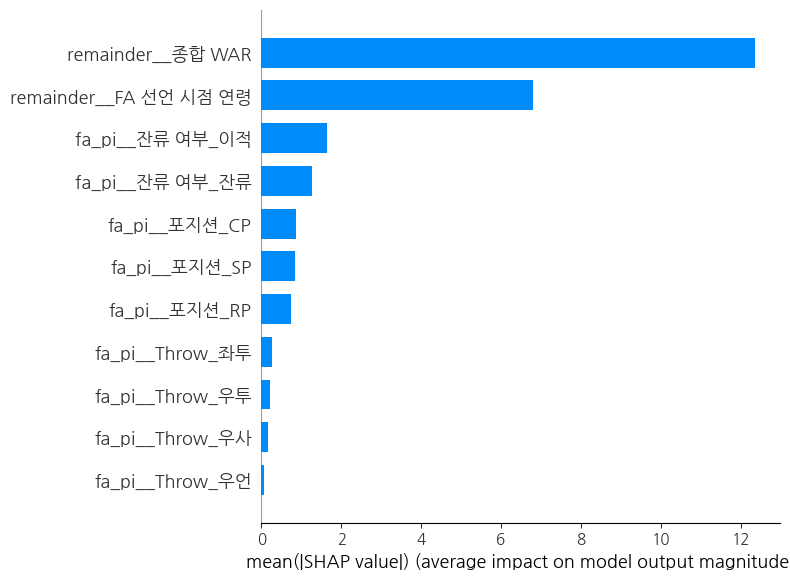

In [ ]:
# shap 차트 구성
rfr_model_pi = pipeline_pi_value_rfr.named_steps['regressor']

explainer_pi_value = shap.Explainer(rfr_model_pi)

x_val_transformed_pi_value = pipeline_pi_value_rfr.named_steps['preprocessing'].transform(x_pi_value_val)

shap_values_pi_value = explainer_pi_value(x_val_transformed_pi_value)

shap.summary_plot(shap_values_pi_value, x_val_transformed_pi_value, feature_names=pipeline_pi_value_rfr.named_steps['preprocessing'].get_feature_names_out(), plot_type='bar')

# 투수 FA 계약 금액에는 나이 요소가 크게 개입됐음을 확인
# 2년 계약 예측에 연령이 특히 크게 영향을 미쳤음 → 노경은, 우규민, 이용찬 등 나이 든 투수가 대부분 2년으로 예측

#### 야수 회귀

In [ ]:
# 컬럼 구분
features_ba = ['포지션', 'Throw', 'Bat', '잔류 여부']

# 전처리기 정의
preprocessor_ba = ColumnTransformer(transformers=[('fa_ba', OneHotEncoder(handle_unknown='ignore'), features_ba)], remainder='passthrough')

# 전체 파이프라인
pipeline_ba_value_rfr = Pipeline(steps=[
    ('preprocessing', preprocessor_ba),
    ('regressor', RandomForestRegressor(n_jobs=-1, random_state=0))
    ])

# 훈련
pipeline_ba_value_rfr.fit(x_ba_value_train, y_ba_value_train)

# 예측
y_pred_ba_value = pipeline_ba_value_rfr.predict(x_ba_value_val)

print(f'R^2 : {r2_score(y_ba_value_val, y_pred_ba_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(y_ba_value_val, y_pred_ba_value) : .0f}억 원')

# 투수 데이터처럼 검증용 데이터에서는 상당히 낮은 예측력

R^2 :  0.4858
RMSE :  24억 원


In [ ]:
# 실제 테스트용 데이터를 예측
y_prediction_ba_value = pipeline_ba_value_rfr.predict(df_ba_25_value)

print(f'R^2 : {r2_score(real_ba_value, y_prediction_ba_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(real_ba_value, y_prediction_ba_value) : .0f}억 원')

# 투수는 굉장히 잘 맞혔는데 야수에선 총액 정확도가 조금 아쉽다

R^2 :  0.6609
RMSE :  20억 원


In [ ]:
# 하이퍼파라미터 튜닝
params_rfr_ba = {'regressor__n_estimators' : [100, 200, 300],
          'regressor__max_depth' : [5, 10, 15],
          'regressor__ccp_alpha' : [0.0001, 0.0005, 0.001]
          }

grid_search_rfr_ba_reg = GridSearchCV(pipeline_ba_value_rfr, param_grid = params_rfr_ba, cv=5, scoring='f1_weighted')

grid_search_rfr_ba_reg.fit(x_ba_value_train, y_ba_value_train)

grid_search_rfr_ba_reg.best_estimator_

# 투수와 같은 조건이 베스트

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fa_ba',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['포지션', 'Throw', 'Bat',
                                                   '잔류 여부'])])),
                ('regressor',
                 RandomForestRegressor(ccp_alpha=0.0001, max_depth=5, n_jobs=-1,
                                       random_state=0))])

In [ ]:
# 최적화한 변수 값으로 재도전
# 컬럼 구분
features_ba = ['포지션', 'Throw', 'Bat', '잔류 여부']

# 전처리기 정의
preprocessor_ba = ColumnTransformer(transformers=[('fa_ba', OneHotEncoder(handle_unknown='ignore'), features_ba)], remainder='passthrough')

# 전체 파이프라인
pipeline_ba_value_rfr = Pipeline(steps=[
    ('preprocessing', preprocessor_ba),
    ('regressor', RandomForestRegressor(n_estimators=100, ccp_alpha=0.0001, max_depth=5,n_jobs=-1, random_state=0))
    ])

# 훈련
pipeline_ba_value_rfr.fit(x_ba_value_train, y_ba_value_train)

# 예측
y_pred_ba_value = pipeline_ba_value_rfr.predict(x_ba_value_val)

print(f'R^2 : {r2_score(y_ba_value_val, y_pred_ba_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(y_ba_value_val, y_pred_ba_value) : .0f}억 원')

# 약간은 좋아진 모습..

R^2 :  0.5183
RMSE :  23억 원


In [ ]:
# 실제 테스트용 데이터를 예측
y_prediction_ba_value = pipeline_ba_value_rfr.predict(df_ba_25_value)

print(f'R^2 : {r2_score(real_ba_value, y_prediction_ba_value) : .4f}')
print(f'RMSE : {root_mean_squared_error(real_ba_value, y_prediction_ba_value) : .0f}억 원')

# 야수는 정확도가 아주 조금 상승!

R^2 :  0.6715
RMSE :  20억 원


In [ ]:
results_df = pd.DataFrame({'선수명' : names_ba_25,
                           '예측 FA 연수' : y_prediction_ba_year.astype('int'),
                           '예측 FA 총액' : y_prediction_ba_value,
                           '실제 FA 연수' : real_ba_year.values.astype('int'),
                           '실제 FA 총액' : real_ba_value.values,
                           })

results_df

# 고액 계약으로 갈수록 정확도가 틀어지는 모습, 특히 최정
# 하주석은 어떤 모델로도 맞히기 힘든 특이 케이스이니 예외로 삼아도 ok

,선수명,예측 FA 연수,예측 FA 총액,실제 FA 연수,실제 FA 총액
0,김성욱,2,9.744357,3,12.0
1,김헌곤,2,5.599711,2,6.0
2,류지혁,4,19.459252,4,26.0
3,서건창,2,7.639128,2,5.0
4,심우준,4,21.894395,4,50.0
5,최정,4,66.858357,4,110.0
6,하주석,3,17.632287,1,1.1
7,허경민,4,32.015857,4,40.0


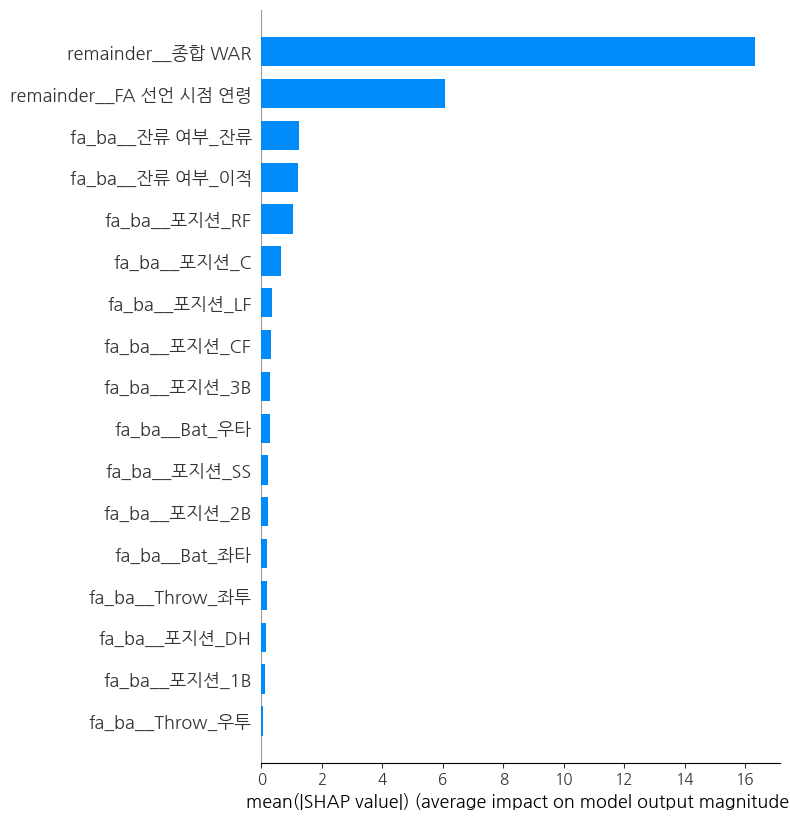

In [ ]:
# 파이프라인에서 모델 꺼내기
rfr_model_ba = pipeline_ba_value_rfr.named_steps['regressor']

# shap explainer 생성
explainer_ba_value = shap.Explainer(rfr_model_ba)

# 전처리 후의 입력 데이터 얻기 (transform만)
x_val_transformed_ba_value = pipeline_ba_value_rfr.named_steps['preprocessing'].transform(x_ba_value_val)

# shap 값 계산
shap_values_ba_value = explainer_ba_value(x_val_transformed_ba_value)

# 요약 플롯
shap.summary_plot(shap_values_ba_value, x_val_transformed_ba_value, feature_names=pipeline_ba_value_rfr.named_steps['preprocessing'].get_feature_names_out(), plot_type='bar')
)

# 투수 FA 계약 금액에는 나이 요소가 크게 개입됐음을 확인
# 2년 계약 예측에 연령이 특히 크게 영향을 미쳤음 → 노경은, 우규민, 이용찬 등 나이 든 투수가 대부분 2년으로 예측